# Install needed libraries

In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

path = "/content/gdrive/MyDrive/Chuyên đề nghiên cứu 1/"
%cd {path}
!ls

Mounted at /content/gdrive
/content/gdrive/MyDrive/Chuyên đề nghiên cứu 1


In [ ]:
!git clone https://github.com/phamdinhkhanh/vnquant
%cd vnquant
!python setup.py install

Cloning into 'vnquant'...
remote: Enumerating objects: 341, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 341 (delta 65), reused 89 (delta 53), pack-reused 237
Receiving objects: 100% (341/341), 1.05 MiB | 8.16 MiB/s, done.
Resolving deltas: 100% (164/164), done.
/content/gdrive/MyDrive/Chuyên đề nghiên cứu 1/vnquant
running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/

In [ ]:
%cd ..
!rm -rf vnquant
!ls

/content/gdrive/MyDrive/Chuyên đề nghiên cứu 1


In [ ]:
!pip freeze | grep vnquant

vnquant==0.1.1


In [ ]:
import vnquant
vnquant.__version__

'0.1.1'

In [ ]:
!pip install plotly
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.2 MB/s eta 0:00:00


In [ ]:
import vnquant.data as dt
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima, ndiffs
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score

#We choose 10 codes from biggest companies on stock exchange in Vietnam

In [ ]:
stock_symbols = ['VIC', 'VCB', 'VNM', 'GAS', 'HVN', 'MWG', 'FPT', 'HPG', 'MSN', 'SAB']
print(stock_symbols)

['VIC', 'VCB', 'VNM', 'GAS', 'HVN', 'MWG', 'FPT', 'HPG', 'MSN', 'SAB']


#Prepare the dataset


In [ ]:
stock_data = {}

for symbol in stock_symbols:
  df = dt.DataLoader(symbols=symbol,
                     start="2014-01-01",
                     end="2024-01-01",
                     minimal=True,
                     data_source="VND")
  stock_data[symbol] = df.download()



In [ ]:
stock_data[stock_symbols[1]]

Attributes,high,low,open,close,avg,volume
Symbols,VCB,VCB,VCB,VCB,VCB,VCB
date,,,,,,
2014-01-02,26.9,26.6,26.9,26.7,26.74,333900.0
2014-01-03,27.3,26.7,26.7,27.2,27.07,813360.0
2014-01-06,27.4,27.0,27.3,27.1,27.17,375890.0
2014-01-07,27.9,27.4,27.5,27.7,27.68,2372530.0
2014-01-08,28.1,27.6,27.8,28.1,27.86,1474370.0
...,...,...,...,...,...,...
2023-12-25,81.8,80.7,80.9,81.8,81.45,1480000.0
2023-12-26,82.8,82.0,82.0,82.8,82.47,1113200.0


In [ ]:
for i in range(len(stock_symbols)):
  stock_data[stock_symbols[i]] = stock_data[stock_symbols[i]].ewm(alpha=0.65).mean()

stock_data[stock_symbols[0]].head()

Attributes,high,low,open,close,avg,volume
Symbols,VIC,VIC,VIC,VIC,VIC,VIC
date,,,,,,
2014-01-02,70.5,69.500000,70.000000,70.000000,69.920000,74950.000000
2014-01-03,70.5,69.500000,70.000000,70.370370,69.979259,87520.370370
2014-01-06,70.5,69.500000,70.339559,70.458404,70.068048,103981.918506
2014-01-07,70.5,69.829951,70.445434,70.485853,70.333297,229454.545080
2014-01-08,70.5,69.941067,70.154373,70.168381,70.128579,151327.251584


In [ ]:
for i in range(len(stock_symbols)):
  stock_data[stock_symbols[i]]['today', str(stock_symbols[i])] = stock_data[stock_symbols[i]]['close'].pct_change()*100

stock_data[stock_symbols[1]].head()

Attributes,high,low,open,close,avg,volume,today
Symbols,VCB,VCB,VCB,VCB,VCB,VCB,VCB
date,,,,,,,
2014-01-02,26.900000,26.600000,26.900000,26.700000,26.740000,3.339000e+05,NaN
2014-01-03,27.196296,26.674074,26.751852,27.070370,26.984444,6.890556e+05,1.387155
2014-01-06,27.334635,26.895416,27.124109,27.090492,27.110458,4.763795e+05,0.074332
2014-01-07,27.707721,27.228392,27.372160,27.492708,27.486300,1.727654e+06,1.484712
2014-01-08,27.964049,27.471213,27.651724,27.889532,27.730488,1.562150e+06,1.443379


In [ ]:
for i in range(len(stock_symbols)):
  stock_data[stock_symbols[i]].replace(0, np.nan, inplace=True)
  stock_data[stock_symbols[i]] = stock_data[stock_symbols[i]].dropna()

stock_data[stock_symbols[8]].head()

Attributes,high,low,open,close,avg,volume,today
Symbols,MSN,MSN,MSN,MSN,MSN,MSN,MSN
date,,,,,,,
2014-01-03,82.629630,81.500000,82.259259,81.629630,81.884444,59922.962963,-0.451671
2014-01-06,82.541596,81.500000,82.083192,81.881154,81.942547,100389.541596,0.308129
2014-01-07,83.174049,81.829951,82.028293,82.289532,82.409397,114122.418543,0.498745
2014-01-08,84.040468,82.267783,82.989953,83.733923,83.115498,139748.439155,1.755254
2014-01-09,84.665312,83.721396,83.973291,84.558388,84.192905,114496.033074,0.984626


In [ ]:
for i in range(len(stock_symbols)):
  stock_data[stock_symbols[i]]['trend', str(stock_symbols[i])] = (stock_data[stock_symbols[i]]['today'].iloc[:] > 0).astype(int)

stock_data[stock_symbols[7]].head()

Attributes,high,low,open,close,avg,volume,today,trend
Symbols,HPG,HPG,HPG,HPG,HPG,HPG,HPG,HPG
date,,,,,,,,
2014-01-03,41.574074,41.000000,41.277778,41.470370,41.300370,424864.814815,0.901144,1
2014-01-06,42.134975,41.339559,41.768251,42.033786,41.802666,443856.451613,1.358598,1
2014-01-07,42.573827,41.907366,42.251134,42.143471,42.302433,337198.725563,0.260945,1
2014-01-08,42.590929,41.967896,42.087035,42.376438,42.418461,350568.775959,0.552796,1
2014-01-09,42.987554,42.314401,42.355957,42.912739,42.666918,513616.296237,1.265564,1


# Visualizing Data

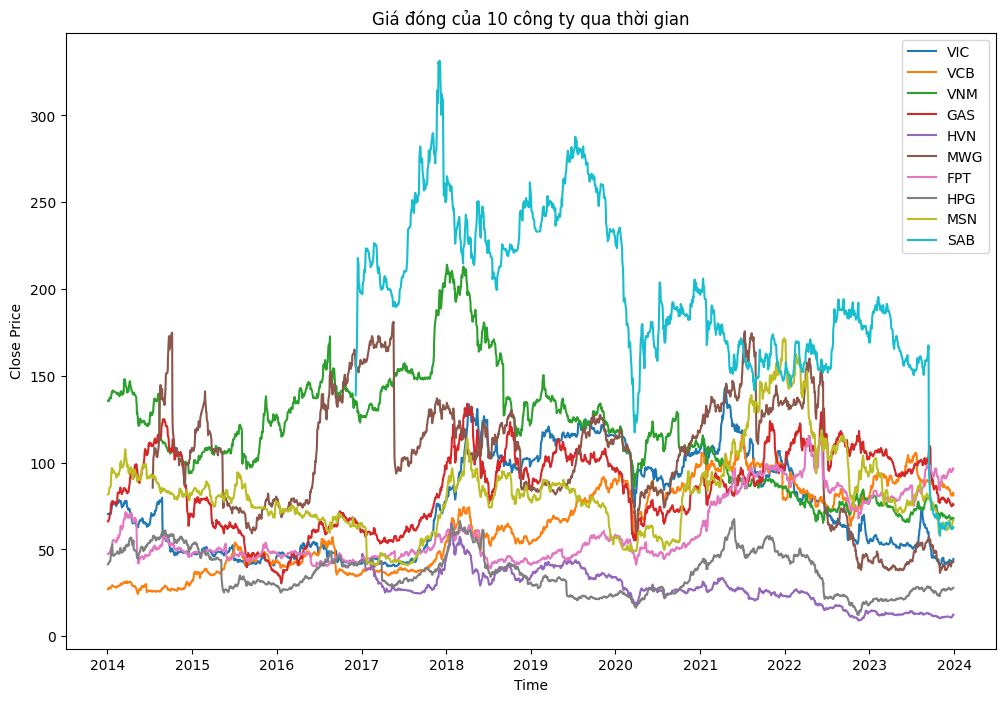

In [ ]:
plt.figure(figsize=(12,8))
plt.title("Giá đóng của 10 công ty qua thời gian")

for symbol in stock_symbols:
  plt.plot(stock_data[symbol].index, stock_data[symbol]['close'], label=symbol)

plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.show()

#ARIMA Model

#VIC

In [ ]:
df = stock_data[stock_symbols[0]]['close']
trend_data = stock_data[stock_symbols[0]]['trend']
d = ndiffs(df, test="adf")
print("Tính toán bậc sai phân của chuỗi giá đóng:", d)

Tính toán bậc sai phân của chuỗi giá đóng: 1


In [ ]:
df_diff = df.diff().dropna()

<Figure size 1800x600 with 0 Axes>

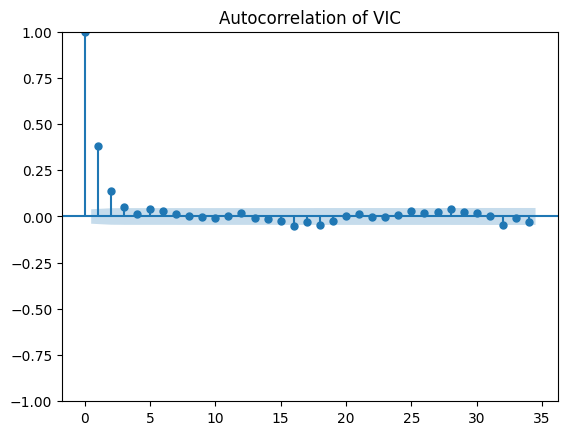

In [ ]:
plt.figure(figsize = (18,6))
ax = plot_acf(df_diff)
plt.title("Autocorrelation of %s" % stock_symbols[0])
plt.show()

<Figure size 1800x600 with 0 Axes>

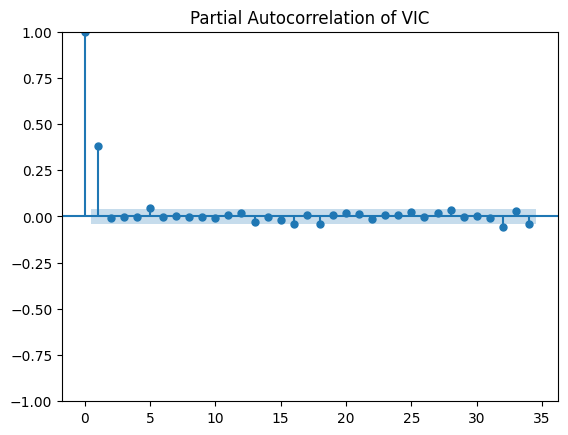

In [ ]:
plt.figure(figsize = (18,6))
ax = plot_pacf(df_diff)
plt.title("Partial Autocorrelation of %s" % stock_symbols[0])
plt.show()

In [ ]:
train_len = int(len(df)*0.8)
train_data = df[:train_len]
test_data = df[train_len:]
trend_test = trend_data[train_len:]

In [ ]:
print('Train data: ', len(train_data))
print('Test data: ', len(test_data))
print('Trend test data:', len(trend_test))

Train data:  1995
Test data:  499
Trend test data: 499


In [ ]:
model = ARIMA(train_data, order=(4,1,7))
result = model.fit()
print(result.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                    VIC   No. Observations:                 1995
Model:                 ARIMA(4, 1, 7)   Log Likelihood               -3003.215
Date:                Tue, 12 Mar 2024   AIC                           6030.431
Time:                        17:28:15   BIC                           6097.606
Sample:                             0   HQIC                          6055.100
                               - 1995                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0634      0.020      3.226      0.001       0.025       0.102
ar.L2          1.4019      0.018     79.050      0.000       1.367       1.437
ar.L3          0.0946      0.019      5.016      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


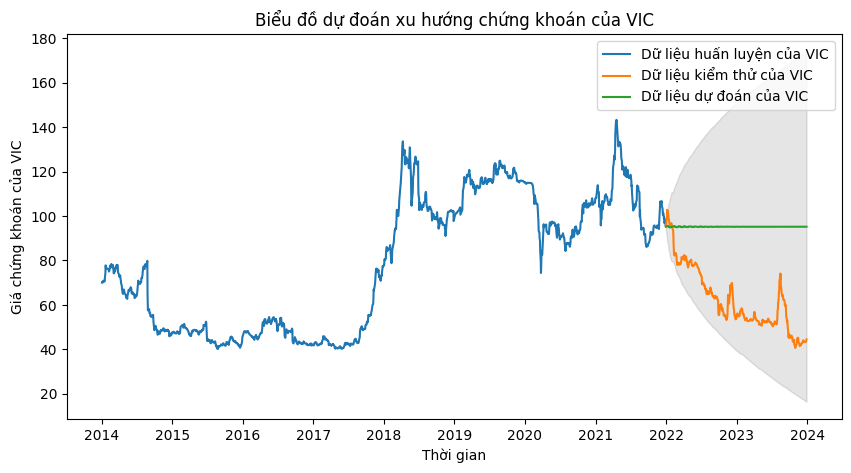

In [ ]:
predict = result.get_forecast(len(test_data))
price_values = predict.predicted_mean.values
conf = predict.conf_int(alpha=0.05)
predict_series = pd.Series(price_values, index=test_data.index.values)
lower_series = pd.Series(conf['lower %s' % stock_symbols[0]].values, index=test_data.index.values)
upper_series = pd.Series(conf['upper %s' % stock_symbols[0]].values, index=test_data.index.values)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label="Dữ liệu huấn luyện của %s" % stock_symbols[0])
plt.plot(test_data, label="Dữ liệu kiểm thử của %s" % stock_symbols[0])
plt.plot(predict_series, label="Dữ liệu dự đoán của %s" % stock_symbols[0])
plt.fill_between(lower_series.index, lower_series, upper_series,
                color='k', alpha=.10)
plt.title('Biểu đồ dự đoán xu hướng chứng khoán của %s' % stock_symbols[0])
plt.xlabel('Thời gian')
plt.ylabel('Giá chứng khoán của %s' % stock_symbols[0])
plt.legend()
plt.show()

In [ ]:
a = predict_series
index = pd.to_datetime(train_data.index.values[-1])
b = pd.Series(train_data.iloc[-1].values, index=[index])
predict = pd.concat([b,a])
predict = predict[1:]
trend_predict = predict.pct_change()*100 > 0
trend_predict = (trend_predict.iloc[:] > 0).astype(int).values
accuracy = accuracy_score(trend_predict, trend_test)
print(f"Accuracy: {accuracy: .2f}")

Accuracy:  0.51


#VCB

#Lựa chọn các tham số (p, d, q) cho ARIMA

In [ ]:
df = stock_data[stock_symbols[1]]['close']
trend_data = stock_data[stock_symbols[1]]['trend']
d = ndiffs(df, test="adf")
print("Tính toán bậc sai phân của chuỗi giá đóng:", d)

Tính toán bậc sai phân của chuỗi giá đóng: 1


In [ ]:
df_diff = df.diff().dropna()

<Figure size 1800x600 with 0 Axes>

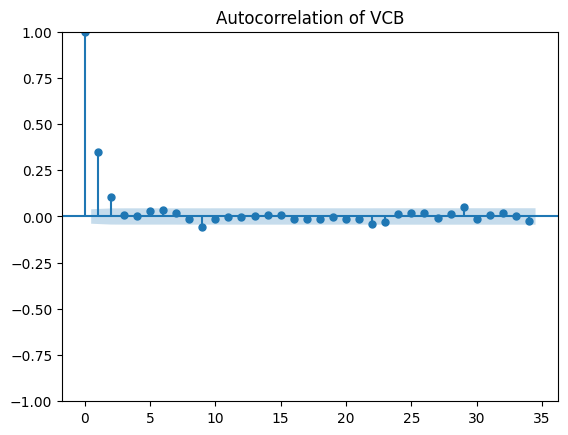

In [ ]:
plt.figure(figsize = (18,6))
ax = plot_acf(df_diff)
plt.title("Autocorrelation of %s" % stock_symbols[1])
plt.show()

<Figure size 1800x600 with 0 Axes>

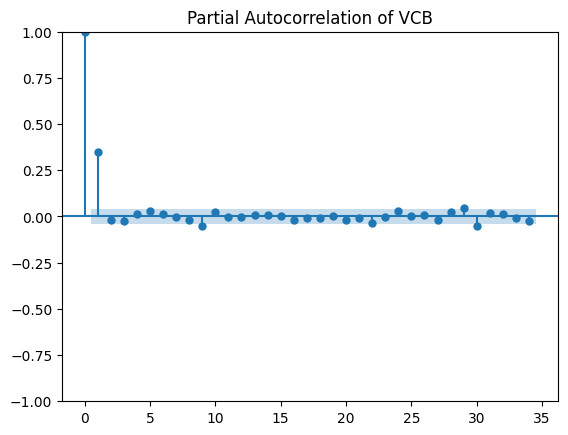

In [ ]:
plt.figure(figsize = (18,6))
ax = plot_pacf(df_diff)
plt.title("Partial Autocorrelation of %s" % stock_symbols[1])
plt.show()

In [ ]:
train_len = int(len(df)*0.8)
train_data = df[:train_len]
test_data = df[train_len:]
trend_test = trend_data[train_len:]

In [ ]:
print('Train data: ', len(train_data))
print('Test data: ', len(test_data))
print('Trend test data:', len(trend_test))

Train data:  1994
Test data:  499
Trend test data: 499


In [ ]:
model = ARIMA(train_data, order=(7,1,4))
result = model.fit()
print(result.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

                               SARIMAX Results                                
Dep. Variable:                    VCB   No. Observations:                 1994
Model:                 ARIMA(7, 1, 4)   Log Likelihood               -2498.281
Date:                Tue, 12 Mar 2024   AIC                           5020.561
Time:                        17:46:00   BIC                           5087.730
Sample:                             0   HQIC                          5045.228
                               - 1994                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0144      0.234      0.061      0.951      -0.445       0.474
ar.L2          0.4974      0.171      2.916      0.004       0.163       0.832
ar.L3         -0.7360      0.114     -6.446      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


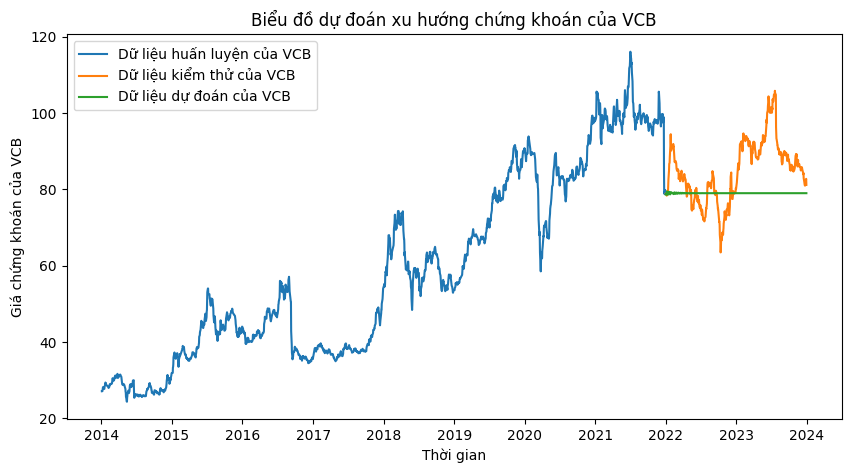

In [ ]:
predict = result.get_forecast(len(test_data))
price_values = predict.predicted_mean.values
conf = predict.conf_int(alpha=0.05)
predict_series = pd.Series(price_values, index=test_data.index.values)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label="Dữ liệu huấn luyện của %s" % stock_symbols[1])
plt.plot(test_data, label="Dữ liệu kiểm thử của %s" % stock_symbols[1])
plt.plot(predict_series, label="Dữ liệu dự đoán của %s" % stock_symbols[1])

plt.title('Biểu đồ dự đoán xu hướng chứng khoán của %s' % stock_symbols[1])
plt.xlabel('Thời gian')
plt.ylabel('Giá chứng khoán của %s' % stock_symbols[1])
plt.legend()
plt.show()


In [ ]:
a = predict_series
index = pd.to_datetime(train_data.index.values[-1])
b = pd.Series(train_data.iloc[-1].values, index=[index])
predict = pd.concat([b,a])
predict = predict[1:]
trend_predict = predict.pct_change()*100 > 0
trend_predict = (trend_predict.iloc[:] > 0).astype(int).values
accuracy = accuracy_score(trend_predict, trend_test)
print(f"Accuracy: {accuracy: .2f}")

Accuracy:  0.53


#VNM

In [ ]:
df = stock_data[stock_symbols[2]]['close']
trend_data = stock_data[stock_symbols[2]]['trend']
d = ndiffs(df, test="adf")
print("Tính toán bậc sai phân của chuỗi giá đóng:", d)

Tính toán bậc sai phân của chuỗi giá đóng: 1


In [ ]:
df_diff = df.diff().dropna()

<Figure size 1800x600 with 0 Axes>

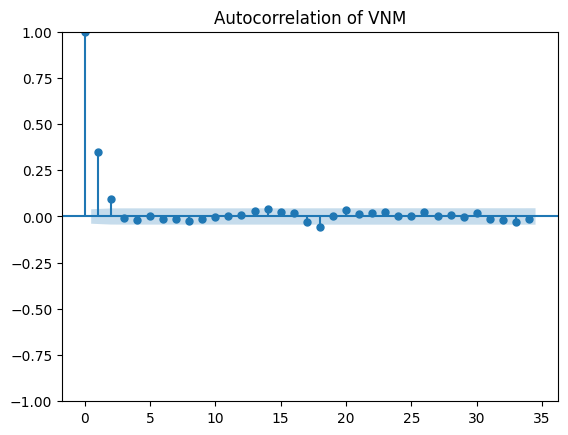

In [ ]:
plt.figure(figsize = (18,6))
ax = plot_acf(df_diff)
plt.title("Autocorrelation of %s" % stock_symbols[2])
plt.show()

<Figure size 1800x600 with 0 Axes>

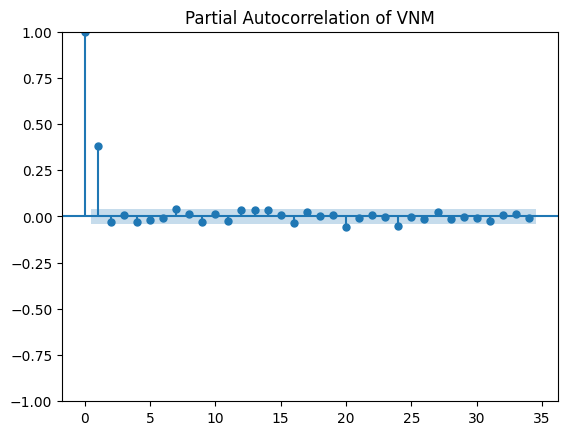

In [ ]:
plt.figure(figsize = (18,6))
ax = plot_pacf(df_diff)
plt.title("Partial Autocorrelation of %s" % stock_symbols[2])
plt.show()

In [ ]:
train_len = int(len(df)*0.8)
train_data = df[:train_len]
test_data = df[train_len:]
trend_test = trend_data[train_len:]

In [ ]:
print('Train data: ', len(train_data))
print('Test data: ', len(test_data))
print('Trend test data:', len(trend_test))

Train data:  1994
Test data:  499
Trend test data: 499


In [ ]:
model = ARIMA(train_data, order=(10,1,6))
result = model.fit()
print(result.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

                               SARIMAX Results                                
Dep. Variable:                    VNM   No. Observations:                 1994
Model:                ARIMA(10, 1, 6)   Log Likelihood               -3638.210
Date:                Tue, 12 Mar 2024   AIC                           7310.420
Time:                        17:51:03   BIC                           7405.575
Sample:                             0   HQIC                          7345.365
                               - 1994                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4097      0.731     -0.561      0.575      -1.842       1.022
ar.L2          0.3088      0.287      1.075      0.282      -0.254       0.872
ar.L3          0.2928      0.332      0.883      0.3

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


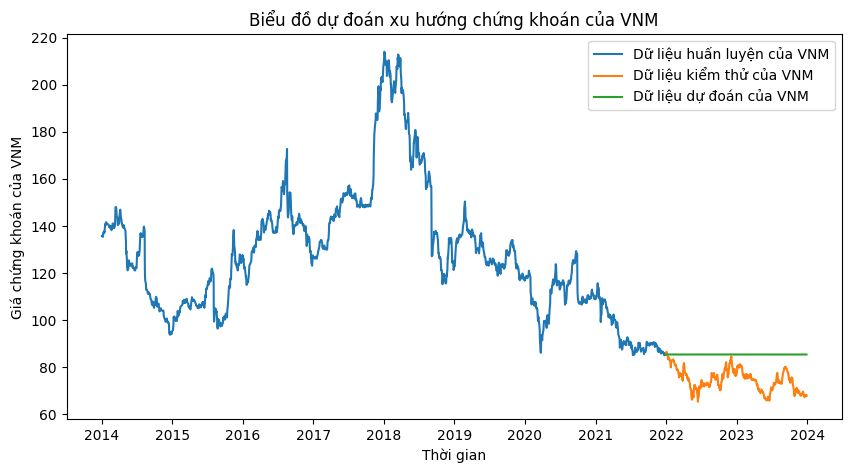

In [ ]:
predict = result.get_forecast(len(test_data))
price_values = predict.predicted_mean.values
conf = predict.conf_int(alpha=0.05)
predict_series = pd.Series(price_values, index=test_data.index.values)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label="Dữ liệu huấn luyện của %s" % stock_symbols[2])
plt.plot(test_data, label="Dữ liệu kiểm thử của %s" % stock_symbols[2])
plt.plot(predict_series, label="Dữ liệu dự đoán của %s" % stock_symbols[2])

plt.title('Biểu đồ dự đoán xu hướng chứng khoán của %s' % stock_symbols[2])
plt.xlabel('Thời gian')
plt.ylabel('Giá chứng khoán của %s' % stock_symbols[2])
plt.legend()
plt.show()


In [ ]:
a = predict_series
index = pd.to_datetime(train_data.index.values[-1])
b = pd.Series(train_data.iloc[-1].values, index=[index])
predict = pd.concat([b,a])
predict = predict[1:]
trend_predict = predict.pct_change()*100 > 0
trend_predict = (trend_predict.iloc[:] > 0).astype(int).values
accuracy = accuracy_score(trend_predict, trend_test)
print(f"Accuracy: {accuracy: .2f}")

Accuracy:  0.54


#GAS

In [ ]:
df = stock_data[stock_symbols[3]]['close']
trend_data = stock_data[stock_symbols[3]]['trend']
d = ndiffs(df, test="adf")
print("Tính toán bậc sai phân của chuỗi giá đóng:", d)

Tính toán bậc sai phân của chuỗi giá đóng: 1


In [ ]:
df_diff = df.diff().dropna()

<Figure size 1800x600 with 0 Axes>

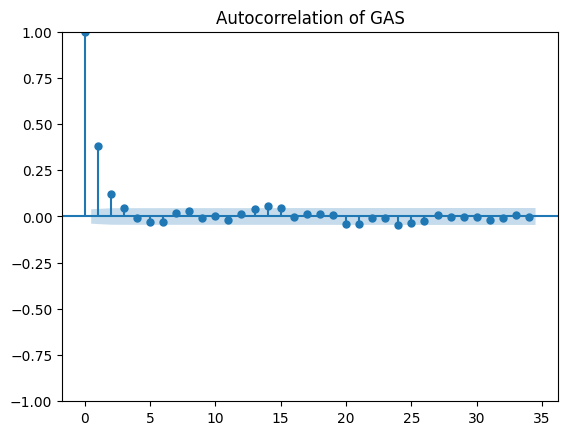

In [ ]:
plt.figure(figsize = (18,6))
ax = plot_acf(df_diff)
plt.title("Autocorrelation of %s" % stock_symbols[3])
plt.show()

<Figure size 1800x600 with 0 Axes>

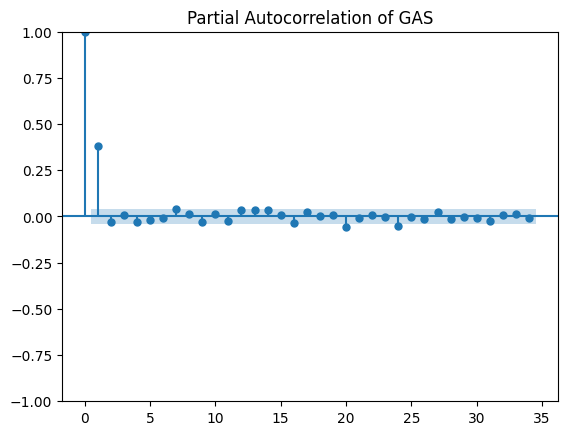

In [ ]:
plt.figure(figsize = (18,6))
ax = plot_pacf(df_diff)
plt.title("Partial Autocorrelation of %s" % stock_symbols[3])
plt.show()

In [ ]:
train_len = int(len(df)*0.8)
train_data = df[:train_len]
test_data = df[train_len:]
trend_test = trend_data[train_len:]

In [ ]:
print('Train data: ', len(train_data))
print('Test data: ', len(test_data))
print('Trend test data:', len(trend_test))

Train data:  1994
Test data:  499
Trend test data: 499


In [ ]:
model = ARIMA(train_data, order=(6,1,10))
result = model.fit()
print(result.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                    GAS   No. Observations:                 1994
Model:                ARIMA(6, 1, 10)   Log Likelihood               -3255.007
Date:                Tue, 12 Mar 2024   AIC                           6544.014
Time:                        17:55:22   BIC                           6639.170
Sample:                             0   HQIC                          6578.959
                               - 1994                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7925      0.203      3.913      0.000       0.396       1.189
ar.L2         -0.0186      0.301     -0.062      0.951      -0.609       0.572
ar.L3         -0.6498      0.235     -2.766      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


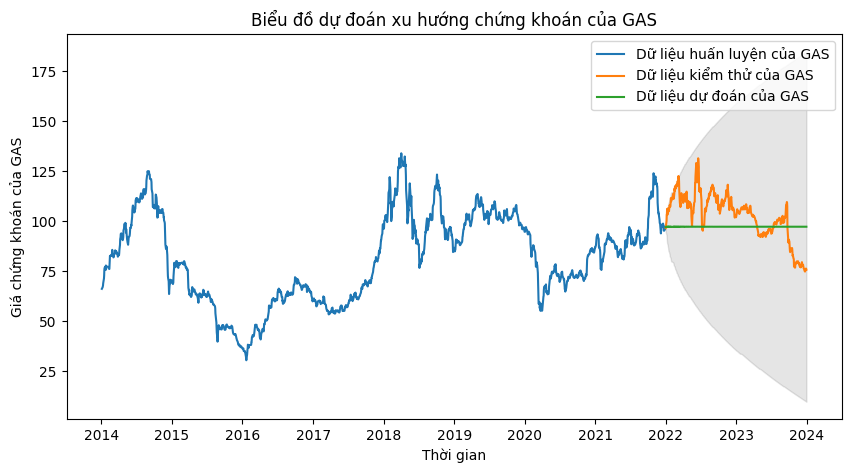

In [ ]:
predict = result.get_forecast(len(test_data))
price_values = predict.predicted_mean.values
conf = predict.conf_int(alpha=0.05)
predict_series = pd.Series(price_values, index=test_data.index.values)
lower_series = pd.Series(conf['lower %s' % stock_symbols[3]].values, index=test_data.index.values)
upper_series = pd.Series(conf['upper %s' % stock_symbols[3]].values, index=test_data.index.values)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label="Dữ liệu huấn luyện của %s" % stock_symbols[3])
plt.plot(test_data, label="Dữ liệu kiểm thử của %s" % stock_symbols[3])
plt.plot(predict_series, label="Dữ liệu dự đoán của %s" % stock_symbols[3])
plt.fill_between(lower_series.index, lower_series, upper_series,
                color='k', alpha=.10)
plt.title('Biểu đồ dự đoán xu hướng chứng khoán của %s' % stock_symbols[3])
plt.xlabel('Thời gian')
plt.ylabel('Giá chứng khoán của %s' % stock_symbols[3])
plt.legend()
plt.show()


In [ ]:
a = predict_series
index = pd.to_datetime(train_data.index.values[-1])
b = pd.Series(train_data.iloc[-1].values, index=[index])
predict = pd.concat([b,a])
predict = predict[1:]
trend_predict = predict.pct_change()*100 > 0
trend_predict = (trend_predict.iloc[:] > 0).astype(int).values
accuracy = accuracy_score(trend_predict, trend_test)
print(f"Accuracy: {accuracy: .2f}")

Accuracy:  0.54


#HVN

In [ ]:
df = stock_data[stock_symbols[4]]['close']
trend_data = stock_data[stock_symbols[4]]['trend']
d = ndiffs(df, test="adf")
print("Tính toán bậc sai phân của chuỗi giá đóng:", d)

Tính toán bậc sai phân của chuỗi giá đóng: 1


In [ ]:
df_diff = df.diff().dropna()

<Figure size 1800x600 with 0 Axes>

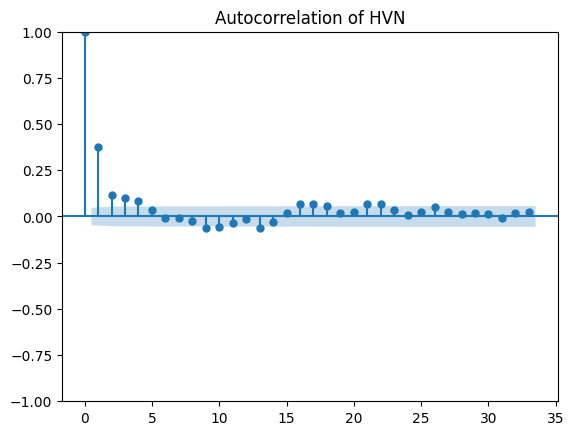

In [ ]:
plt.figure(figsize = (18,6))
ax = plot_acf(df_diff)
plt.title("Autocorrelation of %s" % stock_symbols[4])
plt.show()

<Figure size 1700x600 with 0 Axes>

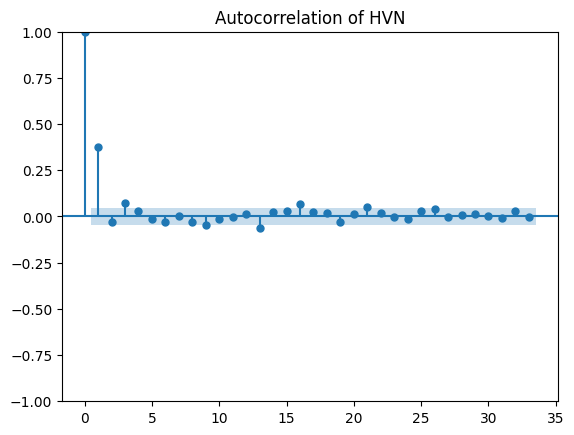

In [ ]:
plt.figure(figsize = (17,6))
ax = plot_pacf(df_diff)
plt.title("Autocorrelation of %s" % stock_symbols[4])
plt.show()

In [ ]:
train_len = int(len(df)*0.8)
train_data = df[:train_len]
test_data = df[train_len:]
trend_test = trend_data[train_len:]

In [ ]:
print('Train data: ', len(train_data))
print('Test data: ', len(test_data))
print('Trend test data: ', len(trend_test))

Train data:  1393
Test data:  349
Trend test data:  349


In [ ]:
model = ARIMA(train_data, order=(4,1,5))
result = model.fit()
print(result.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                    HVN   No. Observations:                 1393
Model:                 ARIMA(4, 1, 5)   Log Likelihood               -1236.534
Date:                Tue, 12 Mar 2024   AIC                           2493.068
Time:                        17:58:17   BIC                           2545.453
Sample:                             0   HQIC                          2512.656
                               - 1393                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4136      0.038     37.102      0.000       1.339       1.488
ar.L2         -1.2261      0.029    -41.792      0.000      -1.284      -1.169
ar.L3          1.4001      0.035     39.934      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


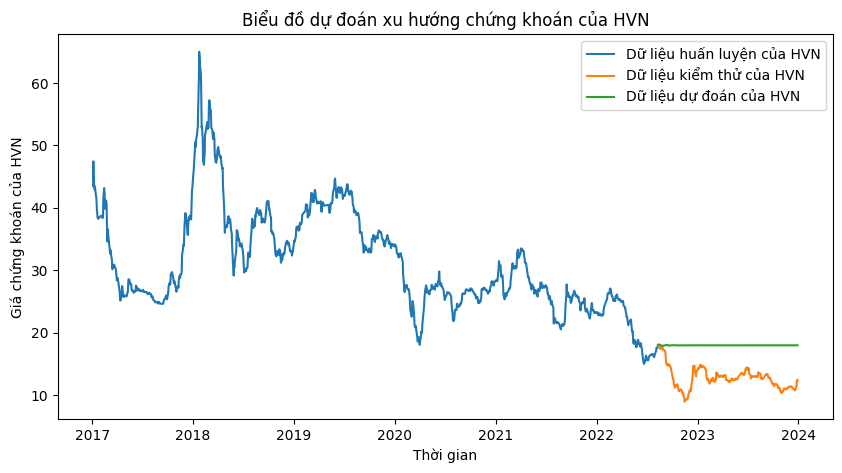

In [ ]:
predict = result.get_forecast(len(test_data))
price_values = predict.predicted_mean.values
conf = predict.conf_int(alpha=0.05)
predict_series = pd.Series(price_values, index=test_data.index.values)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label="Dữ liệu huấn luyện của %s" % stock_symbols[4])
plt.plot(test_data, label="Dữ liệu kiểm thử của %s" % stock_symbols[4])
plt.plot(predict_series, label="Dữ liệu dự đoán của %s" % stock_symbols[4])

plt.title('Biểu đồ dự đoán xu hướng chứng khoán của %s' % stock_symbols[4])
plt.xlabel('Thời gian')
plt.ylabel('Giá chứng khoán của %s' % stock_symbols[4])
plt.legend()
plt.show()

In [ ]:
a = predict_series
index = pd.to_datetime(train_data.index.values[-1])
b = pd.Series(train_data.iloc[-1].values, index=[index])
predict = pd.concat([b,a])
predict = predict[1:]
trend_predict = predict.pct_change()*100 > 0
trend_predict = (trend_predict.iloc[:] > 0).astype(int).values
accuracy = accuracy_score(trend_predict, trend_test)
print(f"Accuracy: {accuracy: .2f}")

Accuracy:  0.54


#MWG

In [ ]:
df = stock_data[stock_symbols[5]]['close']
trend_data = stock_data[stock_symbols[5]]['trend']
d = ndiffs(df, test="adf")
print("Tính toán bậc sai phân của chuỗi giá đóng:", d)

Tính toán bậc sai phân của chuỗi giá đóng: 1


In [ ]:
df_diff = df.diff().dropna()

<Figure size 1800x600 with 0 Axes>

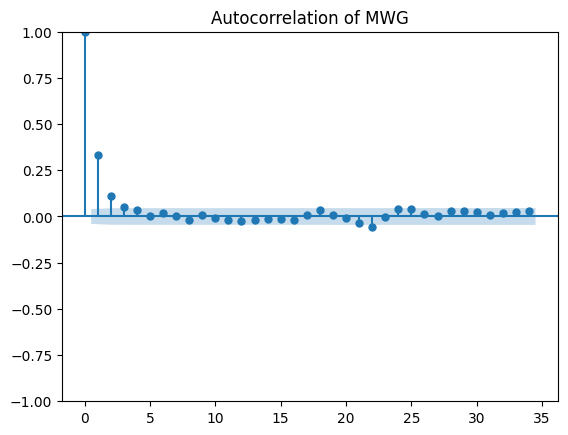

In [ ]:
plt.figure(figsize = (18,6))
ax = plot_acf(df_diff)
plt.title("Autocorrelation of %s" % stock_symbols[5])
plt.show()

<Figure size 1700x600 with 0 Axes>

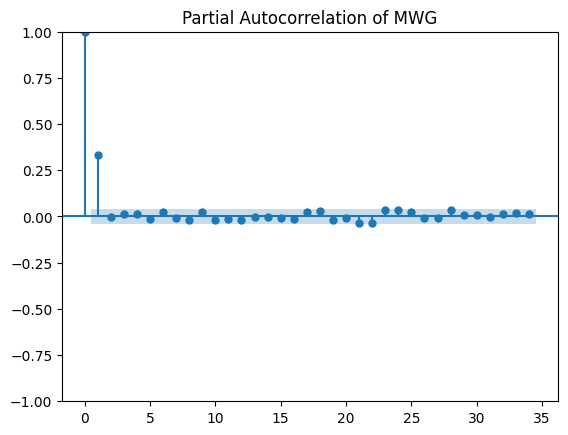

In [ ]:
plt.figure(figsize = (17,6))
ax = plot_pacf(df_diff)
plt.title("Partial Autocorrelation of %s" % stock_symbols[5])
plt.show()

In [ ]:
train_len = int(len(df)*0.8)
train_data = df[:train_len]
test_data = df[train_len:]
trend_test = trend_data[train_len:]

In [ ]:
print('Train data: ', len(train_data))
print('Test data: ', len(test_data))
print('Trend test data: ', len(trend_test))

Train data:  1893
Test data:  474
Trend test data:  474


In [ ]:
model = ARIMA(train_data, order=(10,1,13))
result = model.fit()
print(result.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                    MWG   No. Observations:                 1893
Model:               ARIMA(10, 1, 13)   Log Likelihood               -4378.355
Date:                Tue, 12 Mar 2024   AIC                           8804.711
Time:                        18:00:28   BIC                           8937.800
Sample:                             0   HQIC                          8853.716
                               - 1893                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0769      0.714      1.508      0.132      -0.323       2.476
ar.L2         -0.1831      0.652     -0.281      0.779      -1.461       1.094
ar.L3         -0.1073      0.679     -0.158      0.8

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


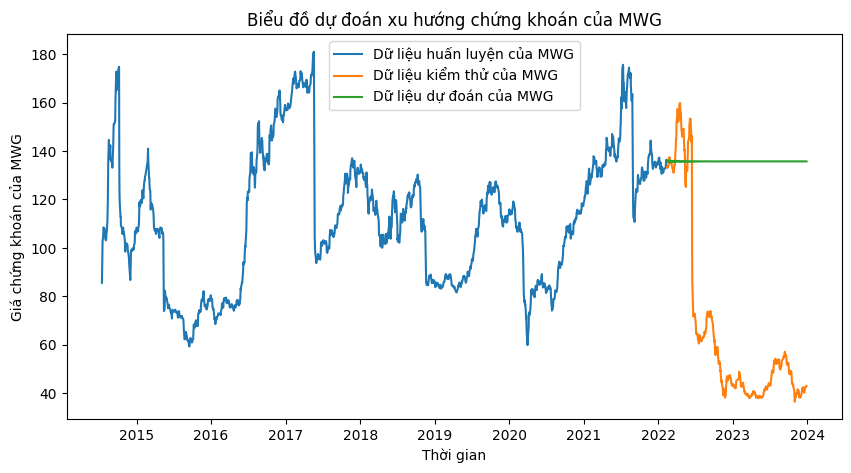

In [ ]:
predict = result.get_forecast(len(test_data))
price_values = predict.predicted_mean.values
conf = predict.conf_int(alpha=0.05)
predict_series = pd.Series(price_values, index=test_data.index.values)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label="Dữ liệu huấn luyện của %s" % stock_symbols[5])
plt.plot(test_data, label="Dữ liệu kiểm thử của %s" % stock_symbols[5])
plt.plot(predict_series, label="Dữ liệu dự đoán của %s" % stock_symbols[5])

plt.title('Biểu đồ dự đoán xu hướng chứng khoán của %s' % stock_symbols[5])
plt.xlabel('Thời gian')
plt.ylabel('Giá chứng khoán của %s' % stock_symbols[5])
plt.legend()
plt.show()


In [ ]:
a = predict_series
index = pd.to_datetime(train_data.index.values[-1])
b = pd.Series(train_data.iloc[-1].values, index=[index])
predict = pd.concat([b,a])
predict = predict[1:]
trend_predict = predict.pct_change()*100 > 0
trend_predict = (trend_predict.iloc[:] > 0).astype(int).values
accuracy = accuracy_score(trend_predict, trend_test)
print(f"Accuracy: {accuracy: .2f}")

Accuracy:  0.52


#FPT

In [ ]:
df = stock_data[stock_symbols[6]]['close']
trend_data = stock_data[stock_symbols[6]]['trend']
d = ndiffs(df, test="adf")
print("Tính toán bậc sai phân của chuỗi giá đóng:", d)

Tính toán bậc sai phân của chuỗi giá đóng: 1


In [ ]:
df_diff = df.diff().dropna()

<Figure size 1800x600 with 0 Axes>

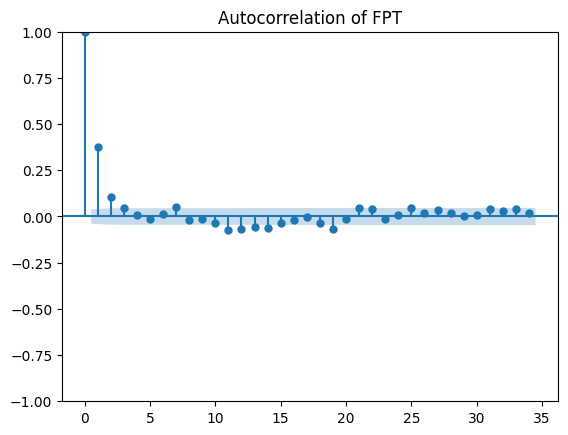

In [ ]:
plt.figure(figsize = (18,6))
ax = plot_acf(df_diff)
plt.title("Autocorrelation of %s" % stock_symbols[6])
plt.show()

<Figure size 1800x600 with 0 Axes>

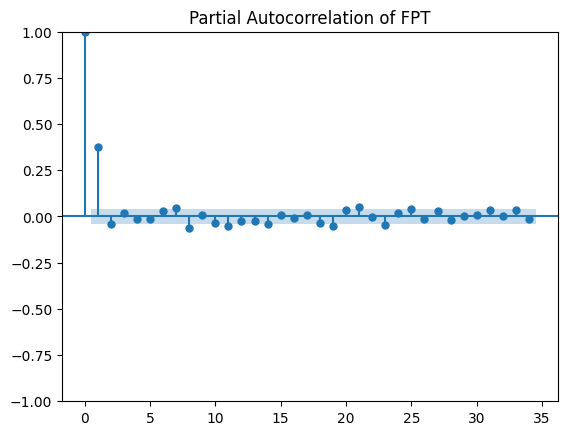

In [ ]:
plt.figure(figsize = (18,6))
ax = plot_pacf(df_diff)
plt.title("Partial Autocorrelation of %s" % stock_symbols[6])
plt.show()

In [ ]:
train_len = int(len(df)*0.8)
train_data = df[:train_len]
test_data = df[train_len:]
trend_test = trend_data[train_len:]

In [ ]:
print('Train data: ', len(train_data))
print('Test data: ', len(test_data))
print('Trend test data: ', len(trend_test))

Train data:  1994
Test data:  499
Trend test data:  499


In [ ]:
model = ARIMA(train_data, order=(6,1,7))
result = model.fit()
print(result.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                    FPT   No. Observations:                 1994
Model:                 ARIMA(6, 1, 7)   Log Likelihood               -2072.725
Date:                Tue, 12 Mar 2024   AIC                           4173.451
Time:                        18:01:51   BIC                           4251.814
Sample:                             0   HQIC                          4202.229
                               - 1994                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3410      0.275      1.242      0.214      -0.197       0.879
ar.L2          0.3971      0.204      1.946      0.052      -0.003       0.797
ar.L3          0.0921      0.185      0.497      0.6

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


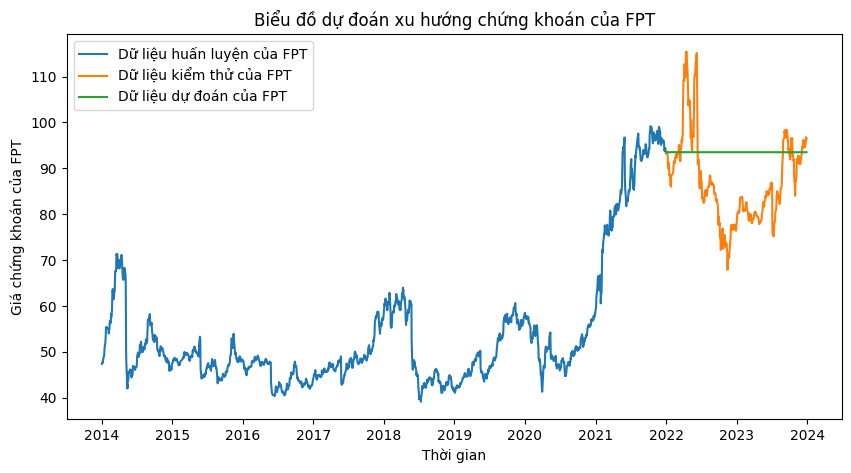

In [ ]:
predict = result.get_forecast(len(test_data))
price_values = predict.predicted_mean.values
conf = predict.conf_int(alpha=0.05)
predict_series = pd.Series(price_values, index=test_data.index.values)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label="Dữ liệu huấn luyện của %s" % stock_symbols[6])
plt.plot(test_data, label="Dữ liệu kiểm thử của %s" % stock_symbols[6])
plt.plot(predict_series, label="Dữ liệu dự đoán của %s" % stock_symbols[6])

plt.title('Biểu đồ dự đoán xu hướng chứng khoán của %s' % stock_symbols[6])
plt.xlabel('Thời gian')
plt.ylabel('Giá chứng khoán của %s' % stock_symbols[6])
plt.legend()
plt.show()


In [ ]:
a = predict_series
index = pd.to_datetime(train_data.index.values[-1])
b = pd.Series(train_data.iloc[-1].values, index=[index])
predict = pd.concat([b,a])
predict = predict[1:]
trend_predict = predict.pct_change()*100 > 0
trend_predict = (trend_predict.iloc[:] > 0).astype(int).values
accuracy = accuracy_score(trend_predict, trend_test)
print(f"Accuracy: {accuracy: .2f}")

Accuracy:  0.53


#HPG

In [ ]:
df = stock_data[stock_symbols[7]]['close']
trend_data = stock_data[stock_symbols[7]]['trend']
d = ndiffs(df, test="adf")
print("Tính toán bậc sai phân của chuỗi giá đóng:", d)

Tính toán bậc sai phân của chuỗi giá đóng: 1


In [ ]:
df_diff = df.diff().dropna()

<Figure size 1800x600 with 0 Axes>

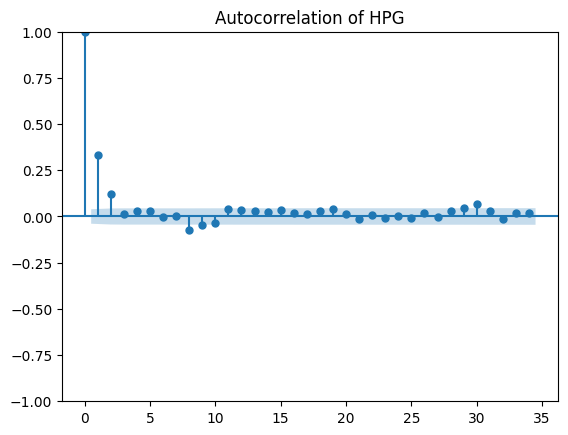

In [ ]:
plt.figure(figsize = (18,6))
ax = plot_acf(df_diff)
plt.title("Autocorrelation of %s" % stock_symbols[7])
plt.show()

<Figure size 1800x600 with 0 Axes>

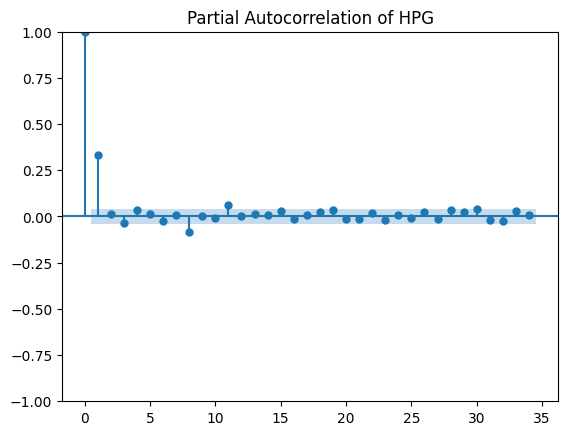

In [ ]:
plt.figure(figsize = (18,6))
ax = plot_pacf(df_diff)
plt.title("Partial Autocorrelation of %s" % stock_symbols[7])
plt.show()

In [ ]:
train_len = int(len(df)*0.8)
train_data = df[:train_len]
test_data = df[train_len:]
trend_test = trend_data[train_len:]

In [ ]:
print('Train data: ', len(train_data))
print('Test data: ', len(test_data))
print('Trend test data: ', len(trend_test))

Train data:  1994
Test data:  499
Trend test data:  499


In [ ]:
model = ARIMA(train_data, order=(5,1,5))
result = model.fit()
print(result.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                    HPG   No. Observations:                 1994
Model:                 ARIMA(5, 1, 5)   Log Likelihood               -2217.954
Date:                Tue, 12 Mar 2024   AIC                           4457.907
Time:                        18:06:51   BIC                           4519.479
Sample:                             0   HQIC                          4480.519
                               - 1994                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0526      0.098     -0.537      0.591      -0.244       0.139
ar.L2          0.6186      0.100      6.174      0.000       0.422       0.815
ar.L3         -0.7572      0.065    -11.622      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


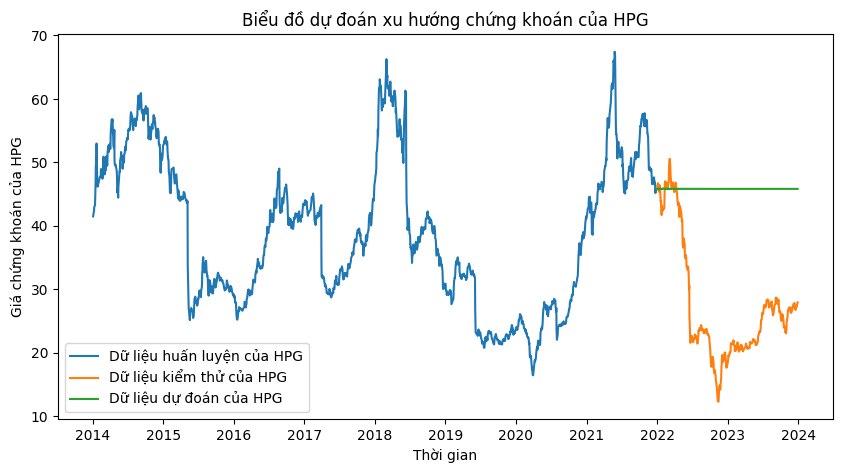

In [ ]:
predict = result.get_forecast(len(test_data))
price_values = predict.predicted_mean.values
conf = predict.conf_int(alpha=0.05)
predict_series = pd.Series(price_values, index=test_data.index.values)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label="Dữ liệu huấn luyện của %s" % stock_symbols[7])
plt.plot(test_data, label="Dữ liệu kiểm thử của %s" % stock_symbols[7])
plt.plot(predict_series, label="Dữ liệu dự đoán của %s" % stock_symbols[7])

plt.title('Biểu đồ dự đoán xu hướng chứng khoán của %s' % stock_symbols[7])
plt.xlabel('Thời gian')
plt.ylabel('Giá chứng khoán của %s' % stock_symbols[7])
plt.legend()
plt.show()

In [ ]:
a = predict_series
index = pd.to_datetime(train_data.index.values[-1])
b = pd.Series(train_data.iloc[-1].values, index=[index])
predict = pd.concat([b,a])
predict = predict[1:]
trend_predict = predict.pct_change()*100 > 0
trend_predict = (trend_predict.iloc[:] > 0).astype(int).values
accuracy = accuracy_score(trend_predict, trend_test)
print(f"Accuracy: {accuracy: .2f}")

Accuracy:  0.52


#MSN

In [ ]:
df = stock_data[stock_symbols[8]]['close']
trend_data = stock_data[stock_symbols[8]]['trend']
d = ndiffs(df, test="adf")
print("Tính toán bậc sai phân của chuỗi giá đóng:", d)

Tính toán bậc sai phân của chuỗi giá đóng: 1


In [ ]:
df_diff = df.diff().dropna()

<Figure size 1800x600 with 0 Axes>

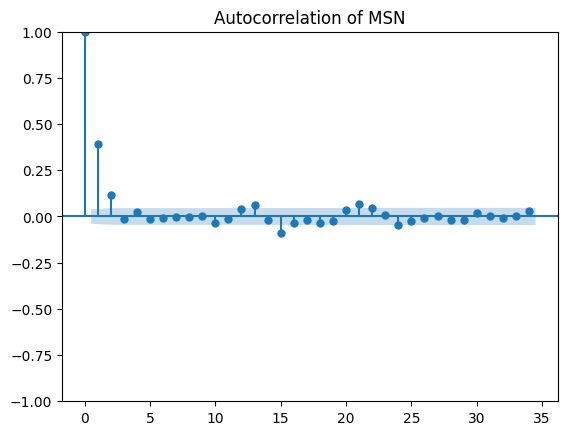

In [ ]:
plt.figure(figsize = (18,6))
ax = plot_acf(df_diff)
plt.title("Autocorrelation of %s" % stock_symbols[8])
plt.show()

<Figure size 1800x600 with 0 Axes>

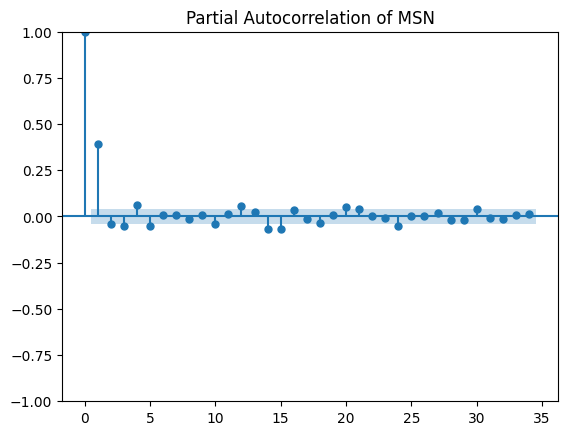

In [ ]:
plt.figure(figsize = (18,6))
ax = plot_pacf(df_diff)
plt.title("Partial Autocorrelation of %s" % stock_symbols[8])
plt.show()

In [ ]:
train_len = int(len(df)*0.8)
train_data = df[:train_len]
test_data = df[train_len:]
trend_test = trend_data[train_len:]

In [ ]:
print('Train data: ', len(train_data))
print('Test data: ', len(test_data))
print('Trend test data: ', len(trend_test))

Train data:  1994
Test data:  499
Trend test data:  499


In [ ]:
model = ARIMA(train_data, order=(5,1,10))
result = model.fit()
print(result.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                    MSN   No. Observations:                 1994
Model:                ARIMA(5, 1, 10)   Log Likelihood               -3070.991
Date:                Tue, 12 Mar 2024   AIC                           6173.983
Time:                        18:09:25   BIC                           6263.541
Sample:                             0   HQIC                          6206.873
                               - 1994                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3483      0.151      2.302      0.021       0.052       0.645
ar.L2         -0.6206      0.132     -4.709      0.000      -0.879      -0.362
ar.L3         -0.6739      0.147     -4.600      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


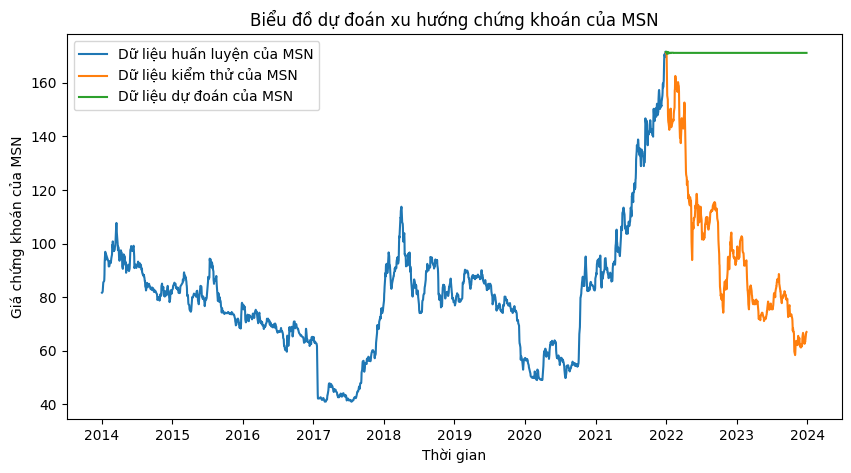

In [ ]:
predict = result.get_forecast(len(test_data))
price_values = predict.predicted_mean.values
conf = predict.conf_int(alpha=0.05)
predict_series = pd.Series(price_values, index=test_data.index.values)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label="Dữ liệu huấn luyện của %s" % stock_symbols[8])
plt.plot(test_data, label="Dữ liệu kiểm thử của %s" % stock_symbols[8])
plt.plot(predict_series, label="Dữ liệu dự đoán của %s" % stock_symbols[8])

plt.title('Biểu đồ dự đoán xu hướng chứng khoán của %s' % stock_symbols[8])
plt.xlabel('Thời gian')
plt.ylabel('Giá chứng khoán của %s' % stock_symbols[8])
plt.legend()
plt.show()


In [ ]:
a = predict_series
index = pd.to_datetime(train_data.index.values[-1])
b = pd.Series(train_data.iloc[-1].values, index=[index])
predict = pd.concat([b,a])
predict = predict[1:]
trend_predict = predict.pct_change()*100 > 0
trend_predict = (trend_predict.iloc[:] > 0).astype(int).values
accuracy = accuracy_score(trend_predict, trend_test)
print(f"Accuracy: {accuracy: .2f}")

Accuracy:  0.54


#SAB

In [ ]:
df = stock_data[stock_symbols[9]]['close']
trend_data = stock_data[stock_symbols[9]]['trend']
d = ndiffs(df, test="adf")
print("Tính toán bậc sai phân của chuỗi giá đóng:", d)

Tính toán bậc sai phân của chuỗi giá đóng: 1


In [ ]:
df_diff = df.diff().dropna()

<Figure size 1800x600 with 0 Axes>

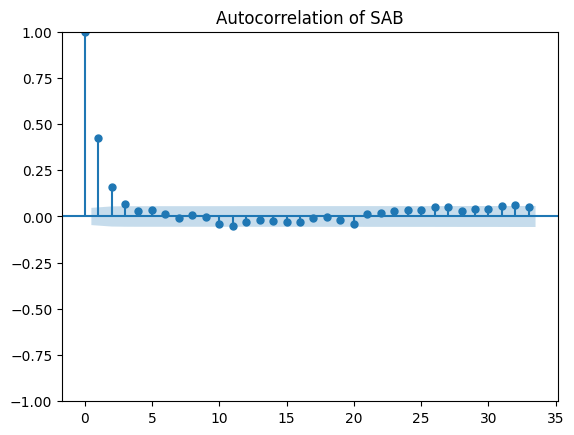

In [ ]:
plt.figure(figsize = (18,6))
ax = plot_acf(df_diff)
plt.title("Autocorrelation of %s" % stock_symbols[9])
plt.show()

<Figure size 1800x600 with 0 Axes>

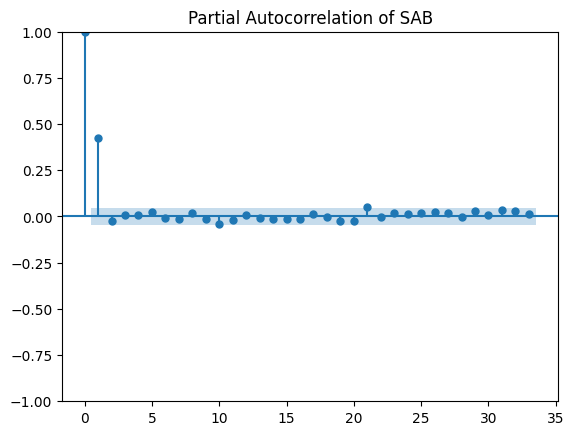

In [ ]:
plt.figure(figsize = (18,6))
ax = plot_pacf(df_diff)
plt.title("Partial Autocorrelation of %s" % stock_symbols[9])
plt.show()

In [ ]:
train_len = int(len(df)*0.8)
train_data = df[:train_len]
test_data = df[train_len:]
trend_test = trend_data[train_len:]

In [ ]:
print('Train data: ', len(train_data))
print('Test data: ', len(test_data))
print('Trend test data: '), len(trend_test)

Train data:  1412
Test data:  354
Trend test data: 


(None, 354)

In [ ]:
model = ARIMA(train_data, order=(2,1,3))
result = model.fit()
print(result.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    SAB   No. Observations:                 1412
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -3327.851
Date:                Tue, 12 Mar 2024   AIC                           6667.702
Time:                        18:10:59   BIC                           6699.214
Sample:                             0   HQIC                          6679.477
                               - 1412                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6197      1.849      0.335      0.738      -3.004       4.244
ar.L2          0.0172      1.070      0.016      0.987      -2.080       2.114
ma.L1         -0.1599      1.850     -0.086      0.9

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


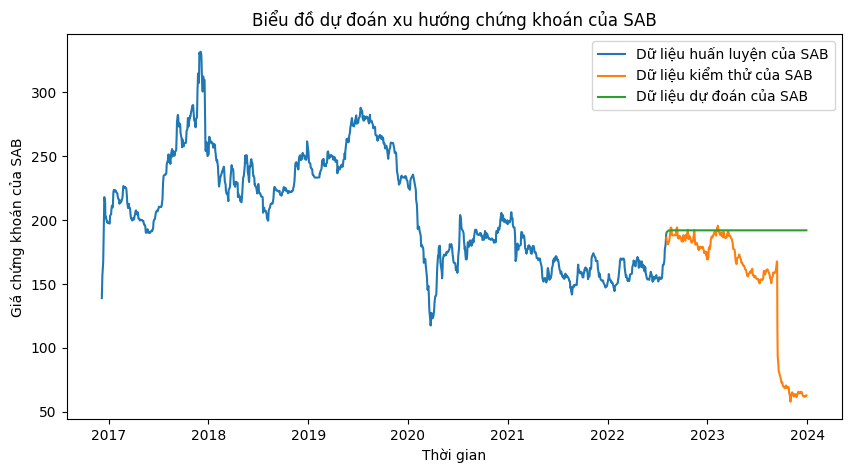

In [ ]:
predict = result.get_forecast(len(test_data))
price_values = predict.predicted_mean.values
conf = predict.conf_int(alpha=0.05)
predict_series = pd.Series(price_values, index=test_data.index.values)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label="Dữ liệu huấn luyện của %s" % stock_symbols[9])
plt.plot(test_data, label="Dữ liệu kiểm thử của %s" % stock_symbols[9])
plt.plot(predict_series, label="Dữ liệu dự đoán của %s" % stock_symbols[9])

plt.title('Biểu đồ dự đoán xu hướng chứng khoán của %s' % stock_symbols[9])
plt.xlabel('Thời gian')
plt.ylabel('Giá chứng khoán của %s' % stock_symbols[9])
plt.legend()
plt.show()


In [ ]:
a = predict_series
index = pd.to_datetime(train_data.index.values[-1])
b = pd.Series(train_data.iloc[-1].values, index=[index])
predict = pd.concat([b,a])
predict = predict[1:]
trend_predict = predict.pct_change()*100 > 0
trend_predict = (trend_predict.iloc[:] > 0).astype(int).values
accuracy = accuracy_score(trend_predict, trend_test)
print(f"Accuracy: {accuracy: .2f}")

Accuracy:  0.56


#The End
